# Emotion Recognition from Speech using Mel Spectrograms and CNNs 

In [30]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [31]:
import os
import librosa
import pandas as pd

# Set your dataset path
dataset_path = "data/all_emotion"

# List all .wav files
wav_files = [f for f in os.listdir(dataset_path) if f.endswith('.wav')]

# Collect metadata
metadata = []
for file in wav_files:
    file_path = os.path.join(dataset_path, file)
    y, sr = librosa.load(file_path, sr=None)  # Load the audio
    duration = librosa.get_duration(y=y, sr=sr)  # Get duration
    metadata.append({
        "file_name": file,
        "file_path": file_path,
        "sample_rate": sr,
        "duration_sec": duration
    })

# Convert metadata to a DataFrame
df_metadata = pd.DataFrame(metadata)

df_metadata.head()

,file_name,file_path,sample_rate,duration_sec
0,h04 (3).wav,data/all_emotion/h04 (3).wav,44100,2.556054
1,d03 (5)b.wav,data/all_emotion/d03 (5)b.wav,44100,7.115873
2,h14 (3).wav,data/all_emotion/h14 (3).wav,44100,2.214354
3,d17 (3).wav,data/all_emotion/d17 (3).wav,44100,5.600000
4,d07 (3).wav,data/all_emotion/d07 (3).wav,44100,3.032562


## Data exploration

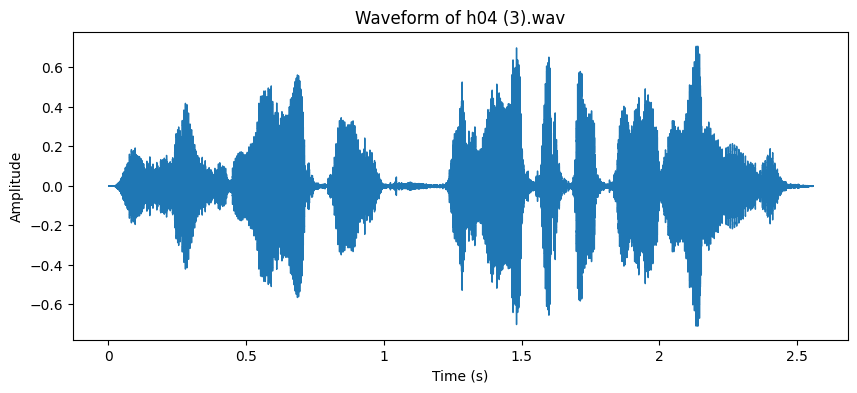

In [32]:
import matplotlib.pyplot as plt

# Plot the waveform of the first file
file_to_plot = metadata[0]['file_path']
y, sr = librosa.load(file_to_plot, sr=None)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform of {metadata[0]['file_name']}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [33]:
# Extract emotion labels from file names
df_metadata['emotion'] = df_metadata['file_name'].str[0]  # Assumes the first letter of the file name indicates emotion

# Map single-letter codes to emotion names (if available)
emotion_mapping = {
    'a': 'angry',
    'h': 'happy',
    's': 'sad',
    'd': 'disgust',
    'f': 'fear'
}
df_metadata['emotion'] = df_metadata['emotion'].map(emotion_mapping)

# Summarize duration by emotion
emotion_summary = df_metadata.groupby("emotion")["duration_sec"].describe()

# Display the summary to the user

emotion_summary.head(5)

,count,mean,std,min,25%,50%,75%,max
emotion,,,,,,,,
angry,121.0,3.585928,1.262586,1.531882,2.600000,3.376621,4.297891,7.410476
disgust,122.0,4.560497,1.419934,1.900000,3.473067,4.470556,5.470278,9.728277
fear,120.0,3.746690,1.483154,0.981179,2.727874,3.354490,4.533356,9.000000
happy,119.0,4.024161,1.550632,1.936508,2.892551,3.600000,4.665567,9.530476
sad,123.0,4.554217,2.082229,0.000000,3.146224,4.069070,4.974569,12.734853


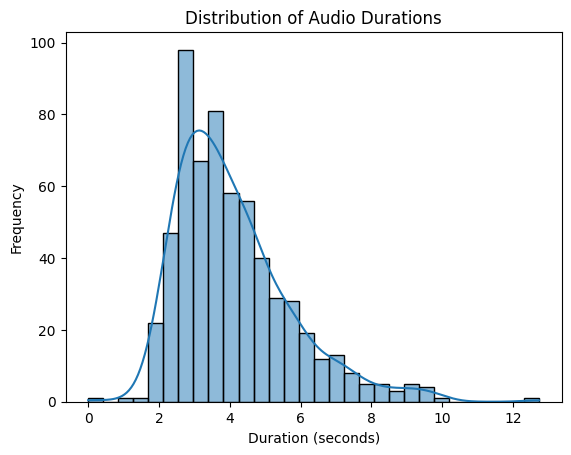

In [34]:
import seaborn as sns

# Histogram of durations
sns.histplot(df_metadata['duration_sec'], bins=30, kde=True)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

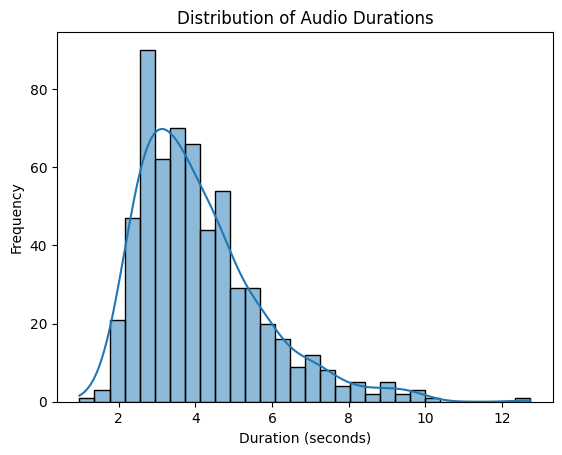

In [35]:
# Remove entries with a duration of 0.0 seconds
df_metadata = df_metadata[df_metadata['duration_sec'] > 0.0]
# Histogram of durations
sns.histplot(df_metadata['duration_sec'], bins=30, kde=True)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

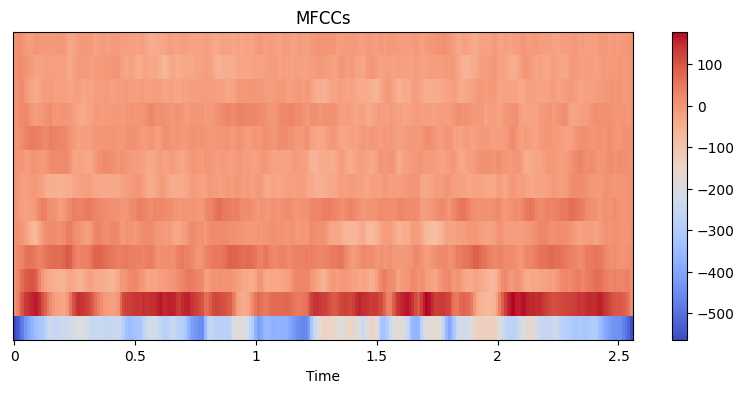

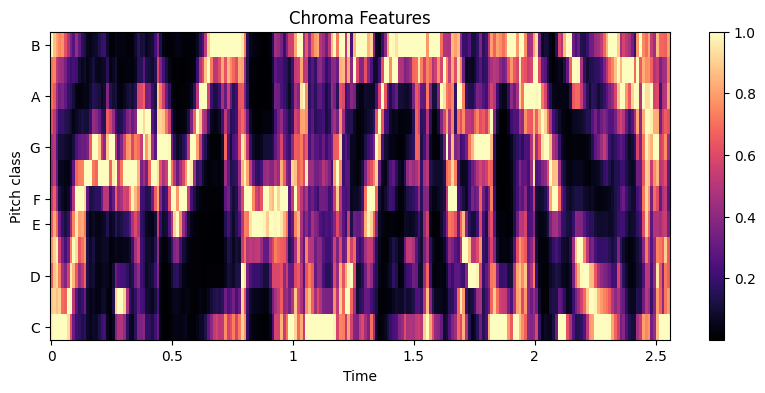

In [36]:
# Extract features for the first file
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Plot MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar()
plt.title("MFCCs")
plt.show()

# Plot Chroma Features
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', sr=sr)
plt.colorbar()
plt.title("Chroma Features")
plt.show()

## Mel Spectogram

In [37]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
import noisereduce as nr


# Function to preprocess a single audio file
def preprocess_audio(file_path, target_sr=None):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=target_sr)
    
    # Noise reduction (simple)
    noise_profile = y[:int(sr * 1)]

# Reduce noise
    y = nr.reduce_noise(y=y, sr=sr, y_noise=noise_profile)
    
    # Normalization
    y = librosa.util.normalize(y)
    
    return y, sr

In [38]:
# Function to convert a signal to a Mel Spectrogram
def audio_to_mel_spectrogram(y, sr, n_mels=128, fmax=8000):
    # Create Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    
    # Convert to log scale for better interpretability
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
    return log_mel_spec

# Visualize a Mel Spectrogram
def plot_mel_spectrogram(mel_spec, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency")
    plt.show()

44100


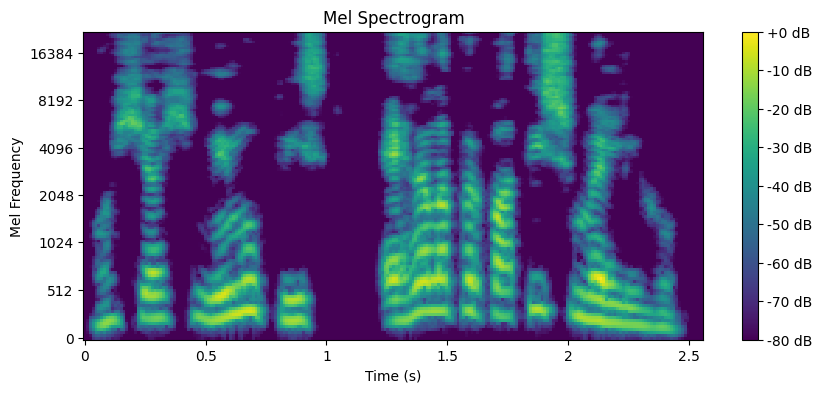

44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
4410

In [39]:
# Ensure your df_metadata contains a 'file_path' column pointing to the audio files
df_metadata['mel_spectrogram'] = None  # Initialize a column for spectrogram data
for index, row in df_metadata.iterrows():
    file_path = row['file_path']
    
    try:
        # Preprocess the audio
        y, sr = preprocess_audio(file_path)
        print(sr)
        
        # Convert to Mel Spectrogram
        mel_spec = audio_to_mel_spectrogram(y, sr)
        
        # Store the Mel Spectrogram in the DataFrame
        df_metadata.at[index, 'mel_spectrogram'] = mel_spec

        # Optional: Visualize the spectrogram for the first file
        if index == 0:  # Show the first file for verification
            plot_mel_spectrogram(mel_spec, sr)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

In [40]:
preprocessed_data = []
for name, mel_spec in zip(df_metadata['file_name'], df_metadata['mel_spectrogram']):
    if mel_spec is not None:
        preprocessed_data.append({
            "file_name": name,
            "mel_spectrogram": mel_spec
        })

In [41]:
import matplotlib.pyplot as plt

output_dir = "processed_spectrograms"
os.makedirs(output_dir, exist_ok=True)

for data in preprocessed_data:
    file_name = data["file_name"].replace(".wav", ".png")
    mel_spec = data["mel_spectrogram"]
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram: {file_name}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, file_name))
    plt.close()

In [106]:
df_metadata['mel_spectrogram'][0].shape

(128, 221)

## CNN

In [51]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()
df_metadata['emotion_encoded'] = label_encoder.fit_transform(df_metadata['emotion'])



# Diviser les données en ensembles d'entraînement et de test
train_df, test_df = train_test_split(df_metadata, test_size=0.2, stratify=df_metadata['emotion_encoded'], random_state=42)

# Vérifier les classes
print("Classes :", label_encoder.classes_)

Classes : ['angry' 'disgust' 'fear' 'happy' 'sad']


In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

class MelSpectrogramDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        mel_spectrogram = row['mel_spectrogram']  # Charger directement l'array
        label = row['emotion_encoded']

        # Normaliser le spectrogramme
        mel_spectrogram = (mel_spectrogram - mel_spectrogram.mean()) / mel_spectrogram.std()

        # Convertir en tenseurs
        mel_tensor = torch.tensor(mel_spectrogram, dtype=torch.float32).unsqueeze(0)  # Ajouter une dimension pour le canal
        label_tensor = torch.tensor(label, dtype=torch.long)

        return mel_tensor, label_tensor


# Créer les datasets
train_dataset = MelSpectrogramDataset(train_df)
test_dataset = MelSpectrogramDataset(test_df)



# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [110]:
train_loader

In [112]:
# Modèle CNN
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Pooling adaptatif
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # Aplatir pour la couche entièrement connectée
        x = self.fc(x)
        return x

# Initialiser le modèle
num_classes = len(label_encoder.classes_)
model = EmotionCNN(num_classes=num_classes)

In [116]:
# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Boucle d'entraînement
num_epochs = 200
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")


Epoch 1/200, Loss: 1.1746
Epoch 2/200, Loss: 1.1530
Epoch 3/200, Loss: 1.1278
Epoch 4/200, Loss: 1.1373
Epoch 5/200, Loss: 1.0842
Epoch 6/200, Loss: 1.1085
Epoch 7/200, Loss: 1.0499
Epoch 8/200, Loss: 1.0584
Epoch 9/200, Loss: 1.0412
Epoch 10/200, Loss: 1.0356
Epoch 11/200, Loss: 1.0266
Epoch 12/200, Loss: 1.0180
Epoch 13/200, Loss: 1.0255
Epoch 14/200, Loss: 0.9947
Epoch 15/200, Loss: 1.0126
Epoch 16/200, Loss: 0.9773
Epoch 17/200, Loss: 0.9752
Epoch 18/200, Loss: 0.9763
Epoch 19/200, Loss: 0.9381
Epoch 20/200, Loss: 0.9630
Epoch 21/200, Loss: 0.9323
Epoch 22/200, Loss: 0.9110
Epoch 23/200, Loss: 0.9005
Epoch 24/200, Loss: 0.9075
Epoch 25/200, Loss: 0.8981
Epoch 26/200, Loss: 0.8745
Epoch 27/200, Loss: 0.8536
Epoch 28/200, Loss: 0.8717
Epoch 29/200, Loss: 0.8791
Epoch 30/200, Loss: 0.8547
Epoch 31/200, Loss: 0.8619
Epoch 32/200, Loss: 0.8605
Epoch 33/200, Loss: 0.8298
Epoch 34/200, Loss: 0.8421
Epoch 35/200, Loss: 0.8311
Epoch 36/200, Loss: 0.8250
Epoch 37/200, Loss: 0.8090
Epoch 38/2

In [121]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = correct / total
    return accuracy

# Évaluer le modèle sur l'ensemble de test
test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 61.98%


In [125]:
for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            print(targets)
            print(predicted)

tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([3])
tensor([2])
tensor([2])
tensor([2])
tensor([4])
tensor([4])
tensor([1])
tensor([1])
tensor([3])
tensor([3])
tensor([0])
tensor([0])
tensor([2])
tensor([3])
tensor([0])
tensor([0])
tensor([1])
tensor([4])
tensor([0])
tensor([0])
tensor([2])
tensor([4])
tensor([0])
tensor([0])
tensor([4])
tensor([4])
tensor([4])
tensor([4])
tensor([2])
tensor([1])
tensor([1])
tensor([1])
tensor([3])
tensor([3])
tensor([3])
tensor([3])
tensor([4])
tensor([4])
tensor([0])
tensor([0])
tensor([3])
tensor([0])
tensor([3])
tensor([3])
tensor([1])
tensor([1])
tensor([2])
tensor([1])
tensor([3])
tensor([3])
tensor([1])
tensor([2])
tensor([4])
tensor([4])
tensor([0])
tensor([0])
tensor([4])
tensor([4])
tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([2])
tensor([2])
tensor([4])
tensor([4])
tensor([0])
tensor([3])
tensor([0])
tensor([0])
tensor([3])
tensor([3])
tensor([0])
tensor([0])
tensor([3])
tensor([2])
tensor([1])
tensor([2])
tensor([4])
tens

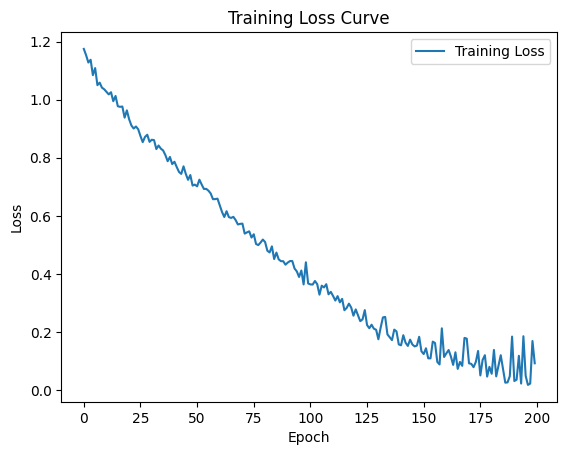

In [118]:
# Afficher la courbe de perte
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()